#  VRP Set Partitioning Formulation

#### Keywords: VRP, Set Partitioning Formulation, IP, Gurobi, Python, Networkx

$ \text{Variables} $

$y_r =
\begin{cases}
1 & \text{if route } r \text{ is used} \\
0 & \text{otherwise}
\end{cases}
\quad \forall r \in \Omega$

$a_{ir} =
\begin{cases}
1 & \text{if route } r \text{ visits customer } i \\
0 & \text{otherwise}
\end{cases}
$

$cost_r$ is the total cost of route $r$,  
$\Omega$ is the set of all feasible routes,  
$K$ is the number of available vehicles.

---

\begin{equation*}
\begin{aligned}
& \underset{}{\text{Minimize}} 
& & \sum_{r \in \Omega} cost_r \cdot y_r \\
& \text{Subject to} \\
& & \sum_{r \in \Omega} a_{ir} \cdot y_r = 1, \quad \forall i = 1,\ldots,n, \\
& & \sum_{r \in \Omega} y_r \le K, \\
& & y_r \in \{0,1\}, \quad \forall r \in \Omega.
\end{aligned}
\end{equation*}


##  Import Library and Model Enviroment

In [1]:
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
m = gp.Model("VRP_SetPartitioning")

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13


### Create Data and Matrix of Distances

In [3]:
# -------------
# Data
# -------------

n_customers = 6
K = 4  # Number of vehicles (so up to 4 routes can be selected)

# Suppose we have enumerated or generated feasible routes:
# Each route r starts at 0 (depot), visits some subset of customers, and returns to 0.
# We'll define "routes_dict" mapping route r -> list of nodes in the route.
routes_dict = {
    0: [0, 1, 2, 0],      # covers customers 1,2
    1: [0, 3, 4, 0],      # covers customers 3,4
    2: [0, 5, 6, 0],      # covers customers 5,6
    3: [0, 1, 4, 6, 0],   # covers customers 1,4,6
    4: [0, 2, 3, 5, 0],   # covers customers 2,3,5
    5: [0, 6, 4, 3, 0],   # covers customers 6,4,3
    6: [0, 2, 5, 4, 0],   # covers customers 2,5,4
    7: [0, 3, 6, 5, 0],   # covers customers 3,6,5
    8: [0, 1, 5, 0],      # covers customers 1,5
    9: [0, 2, 4, 0]       # covers customers 2,4
}

# Define a cost for each route (dummy data for demonstration).
# In real applications, cost would be sum of traveling arcs. 
cost = {
    0: 25,  # route [0,1,2,0]
    1: 20,  # route [0,3,4,0]
    2: 23,  # route [0,5,6,0]
    3: 30,  # route [0,1,4,6,0]
    4: 28,  # route [0,2,3,5,0]
    5: 33,  # route [0,6,4,3,0]
    6: 18,  # route [0,2,5,4,0]
    7: 27,  # route [0,3,6,5,0]
    8: 15,  # route [0,1,5,0]
    9: 22   # route [0,2,4,0]
}

Omega = list(routes_dict.keys())  # route indices

# Build 'a[i,r]' = 1 if route r visits customer i, else 0
a = {}
for r in Omega:
    visited_customers = [node for node in routes_dict[r] if node != 0]  # strip out depot
    for i in range(1, n_customers + 1):
        a[(i, r)] = 1 if i in visited_customers else 0

### Variables

In [4]:
y = m.addVars(Omega, vtype=GRB.BINARY, name="y")

## Mathematical Model of VRP (MTZ Formulation)

### Objective Function

In [5]:
m.setObjective(gp.quicksum(cost[r] * y[r] for r in Omega), GRB.MINIMIZE)

### Subject to:

In [6]:
# 1) Each customer visited exactly once
for i in range(1, n_customers+1):
    if i!=0:
        m.addConstr(gp.quicksum(a[(i,r)] * y[r] for r in Omega) == 1)

In [7]:
# 2) At most K routes
m.addConstr(gp.quicksum(y[r] for r in Omega) <= K)

<gurobi.Constr *Awaiting Model Update*>

### Solve the VRP (Flow-Based Formulation)

Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 11+.0 (26100.2))

CPU model: AMD Ryzen 7 4800H with Radeon Graphics, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 7 rows, 10 columns and 35 nonzeros
Model fingerprint: 0x1dc9bf96
Variable types: 0 continuous, 10 integer (10 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+01, 3e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 68.0000000
Presolve removed 7 rows and 10 columns
Presolve time: 0.00s
Presolve: All rows and columns removed

Explored 0 nodes (0 simplex iterations) in 0.01 seconds (0.00 work units)
Thread count was 1 (of 16 available processors)

Solution count 2: 58 68 

Optimal solution found (tolerance 1.00e-04)
Best objective 5.800000000000e+01, best bound 5.800000000000e+01, gap 0.0000%


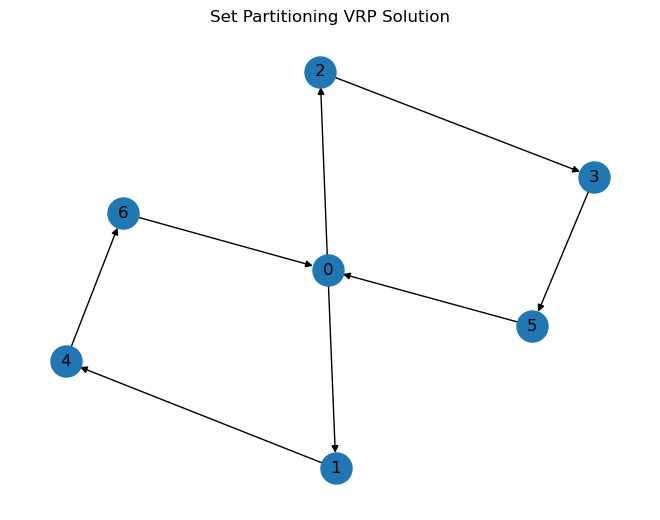

Optimal cost: 58.0
Using route 3: [0, 1, 4, 6, 0]
Using route 4: [0, 2, 3, 5, 0]


In [8]:
m.optimize()

# -------------
# NetworkX Plot
# -------------
if m.status == GRB.OPTIMAL:
    sol_y = m.getAttr('x', y)
    
    # For the plot, we combine all chosen routes into one graph.
    G = nx.DiGraph()
    
    # Add nodes
    for node in range(n_customers+1):
        G.add_node(node)
    
    # For each selected route, add edges
    for r in Omega:
        if sol_y[r] > 0.5:
            route_nodes = routes_dict[r]
            # If route_nodes = [0, 1, 2, 0], we'll draw edges (0->1), (1->2), (2->0).
            for i in range(len(route_nodes)-1):
                G.add_edge(route_nodes[i], route_nodes[i+1])
    
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_size=500)
    # For fun, label edges with "r" just to show which route they came from (optional)
    # or skip edge labels if you prefer.
    plt.title("Set Partitioning VRP Solution")
    plt.show()

    print("Optimal cost:", m.objVal)
    for r in Omega:
        if sol_y[r] > 0.5:
            print(f"Using route {r}: {routes_dict[r]}")

### Literature

Laporte, Gilbert, (2009), Fifty Years of Vehicle Routing, Transportation Science, 43, issue 4, p. 408-416, https://EconPapers.repec.org/RePEc:inm:ortrsc:v:43:y:2009:i:4:p:408-416.